=== Dataset Overview ===
Dataset shape: (19611, 79)
Columns: ['Name', 'e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc', 'e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs', 'e_lfarlc', 'e_ovno', 'e_oemid', 'e_oeminfo', 'e_lfanew', 'Machine', 'NumberOfSections', 'TimeDateStamp', 'PointerToSymbolTable', 'NumberOfSymbols', 'SizeOfOptionalHeader', 'Characteristics', 'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfImage', 'Subsystem', 'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'Malware', 'SuspiciousImportFunctions', 'SuspiciousName

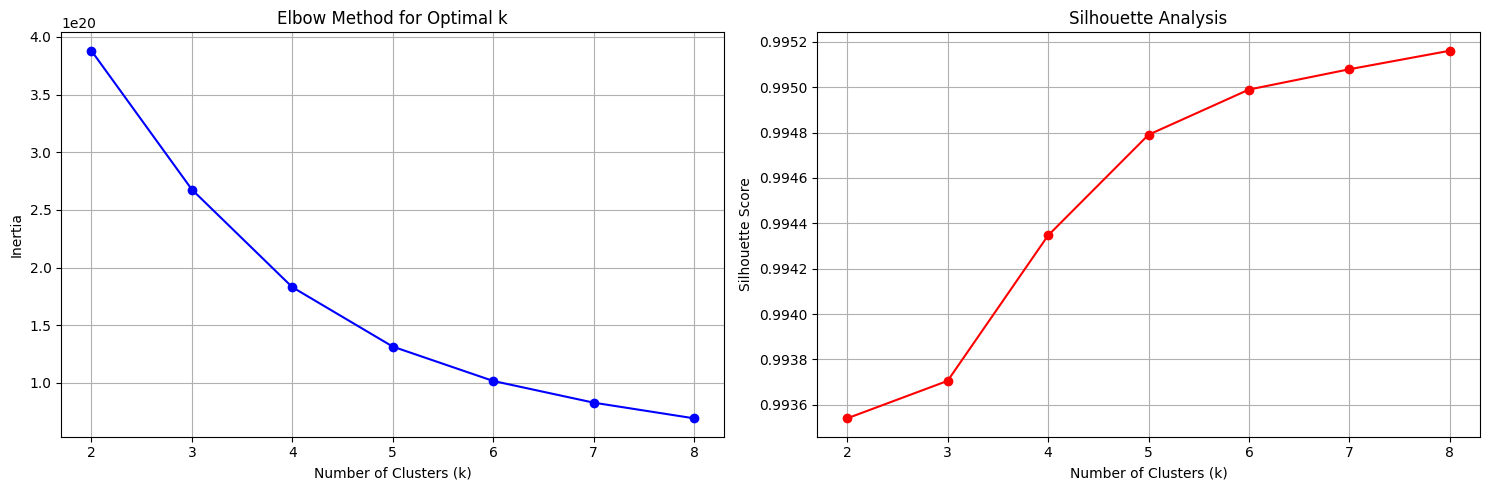


Optimal number of clusters based on silhouette score: k=8

=== Performing K-means Clustering (k=8) ===
Clustering completed!
Silhouette Score: 0.995
Inertia: 69242762993857667072.00

Cluster distribution:
Cluster 0: 19529 samples (99.6%)
Cluster 1: 46 samples (0.2%)
Cluster 2: 8 samples (0.0%)
Cluster 3: 12 samples (0.1%)
Cluster 4: 5 samples (0.0%)
Cluster 5: 5 samples (0.0%)
Cluster 6: 3 samples (0.0%)
Cluster 7: 3 samples (0.0%)

=== Cluster vs Malware Analysis ===
Cluster vs Malware Cross-tabulation:
Malware     0      1    All
Cluster                    
0        5012  14517  19529
1           0     46     46
2           0      8      8
3           0     12     12
4           0      5      5
5           0      5      5
6           0      3      3
7           0      3      3
All      5012  14599  19611

Cluster Purity Analysis:
Cluster 0: 74.3% malware, 25.7% benign
Cluster 1: 100.0% malware, 0.0% benign
Cluster 2: 100.0% malware, 0.0% benign
Cluster 3: 100.0% malware, 0.0% benign

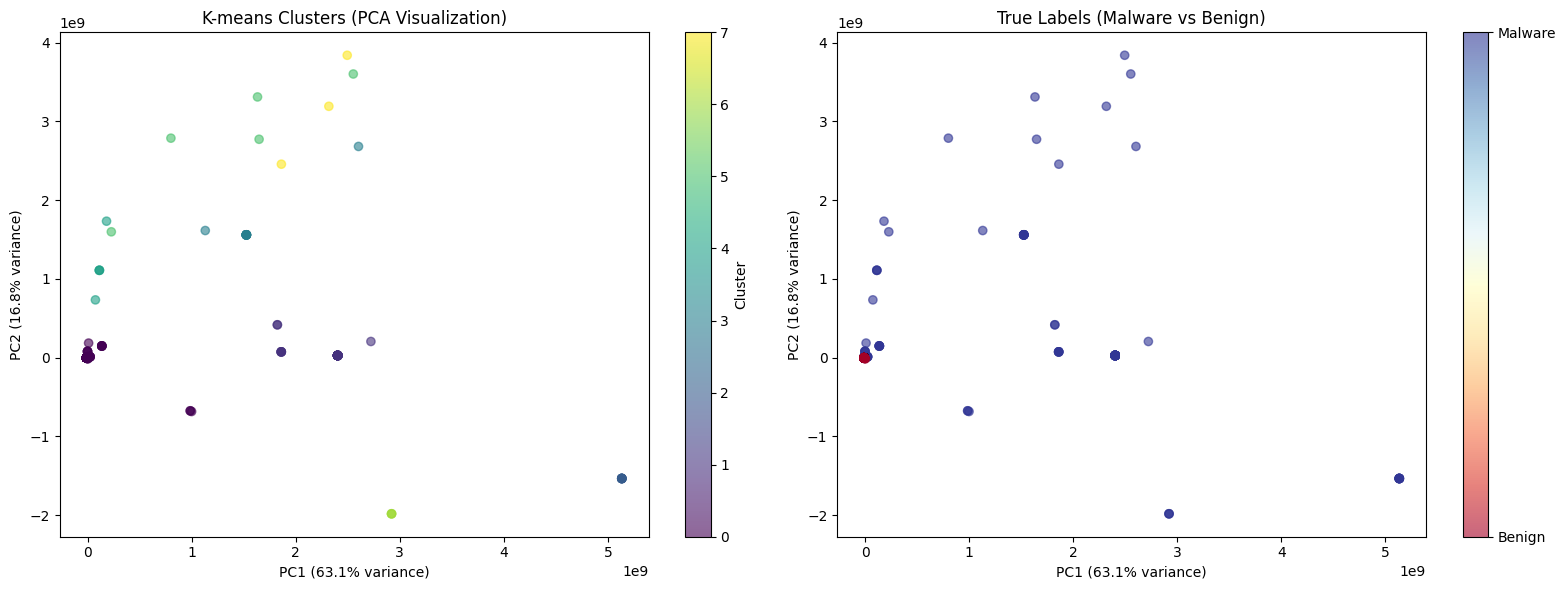


=== Feature Importance Analysis ===
Top 15 most discriminative features:
 1. PointerToSymbolTable          : 1.69e+37
 2. NumberOfSymbols               : 7.26e+36
 3. LoaderFlags                   : 2.96e+36
 4. BaseOfCode                    : 2.69e+34
 5. SectionMaxChar                : 6.21e+30
 6. ImageDirectoryEntryException  : 1.65e+26
 7. NumberOfRvaAndSizes           : 3.83e+24
 8. SizeOfCode                    : 2.57e+24
 9. SizeOfInitializedData         : 4.55e+23
10. CheckSum                      : 7.50e+22
11. SizeOfStackReserve            : 5.65e+19
12. ImageDirectoryEntryExport     : 3.16e+19
13. SizeOfUninitializedData       : 3.10e+19
14. SizeOfStackCommit             : 2.08e+18
15. ImageBase                     : 1.00e+18


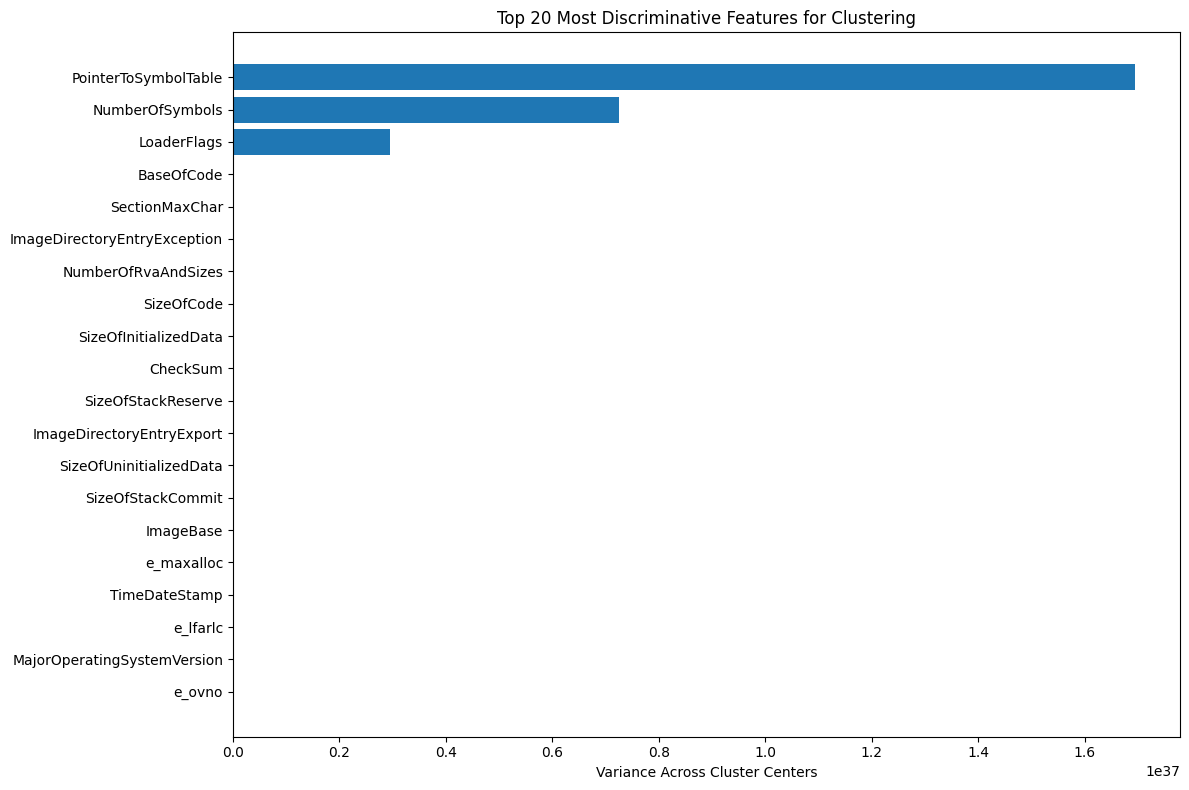


MALWARE K-MEANS CLUSTERING ANALYSIS SUMMARY
Dataset: 19611 samples, 77 features
Number of clusters: 8
Silhouette Score: 0.995
Inertia: 69242762993857667072.00
Adjusted Rand Index: -0.005

Cluster Composition:
  Cluster 0: 19529 samples,  74.3% malware (Malware dominant)
  Cluster 1:    46 samples, 100.0% malware (Malware dominant)
  Cluster 2:     8 samples, 100.0% malware (Malware dominant)
  Cluster 3:    12 samples, 100.0% malware (Malware dominant)
  Cluster 4:     5 samples, 100.0% malware (Malware dominant)
  Cluster 5:     5 samples, 100.0% malware (Malware dominant)
  Cluster 6:     3 samples, 100.0% malware (Malware dominant)
  Cluster 7:     3 samples, 100.0% malware (Malware dominant)

Recommendations:
- Use the identified clusters for malware family detection
- Investigate samples in mixed clusters for potential new threats
- Focus on discriminative features for improved detection models


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class MalwareKMeansAnalyzer:
    def __init__(self, csv_file_path):
        """Initialize the analyzer with the dataset"""
        self.df = pd.read_csv(csv_file_path)
        self.scaler = None
        self.kmeans_model = None
        self.pca_model = None
        self.X_scaled = None
        self.X_pca = None
        self.cluster_labels = None
        
    def load_and_explore_data(self):
        """Load and explore the dataset"""
        print("=== Dataset Overview ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        
        # Check for missing values
        missing_vals = self.df.isnull().sum()
        if missing_vals.sum() > 0:
            print(f"\nMissing values found:")
            print(missing_vals[missing_vals > 0])
        else:
            print("\nNo missing values found!")
            
        # Target distribution
        if 'Malware' in self.df.columns:
            malware_dist = self.df['Malware'].value_counts()
            print(f"\nMalware distribution:")
            print(f"Benign (0): {malware_dist.get(0, 0)}")
            print(f"Malware (1): {malware_dist.get(1, 0)}")
            
        return self.df.head()
    
    def preprocess_data(self):
        """Preprocess the data for clustering"""
        print("\n=== Data Preprocessing ===")
        
        # Separate features from target and identifier
        exclude_cols = ['Name', 'Malware'] if 'Name' in self.df.columns else ['Malware']
        if 'Malware' in self.df.columns:
            self.y_true = self.df['Malware'].values
        
        # Select numeric features only
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        self.X = self.df[feature_cols].copy()
        print(f"Selected {len(feature_cols)} numeric features for clustering")
        
        # Handle any remaining missing values
        self.X = self.X.fillna(self.X.median())
        
        # Scale the features using RobustScaler (less sensitive to outliers)
        self.scaler = RobustScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        
        print("Data preprocessing completed!")
        return self.X_scaled
    
    def find_optimal_clusters(self, max_k=10):
        """Find optimal number of clusters using elbow method and silhouette analysis"""
        print(f"\n=== Finding Optimal Number of Clusters (k=1 to {max_k}) ===")
        
        inertias = []
        silhouette_scores = []
        k_range = range(2, max_k + 1)
        
        # Calculate metrics for different k values
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(self.X_scaled)
            
            inertias.append(kmeans.inertia_)
            sil_score = silhouette_score(self.X_scaled, cluster_labels)
            silhouette_scores.append(sil_score)
            
            print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={sil_score:.3f}")
        
        # Plot elbow curve and silhouette scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Elbow method
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.grid(True)
        
        # Silhouette scores
        ax2.plot(k_range, silhouette_scores, 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Analysis')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Find optimal k (highest silhouette score)
        optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"\nOptimal number of clusters based on silhouette score: k={optimal_k}")
        
        return optimal_k, silhouette_scores
    
    def perform_clustering(self, n_clusters=None):
        """Perform K-means clustering"""
        if n_clusters is None:
            n_clusters, _ = self.find_optimal_clusters()
        
        print(f"\n=== Performing K-means Clustering (k={n_clusters}) ===")
        
        # Fit K-means
        self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.cluster_labels = self.kmeans_model.fit_predict(self.X_scaled)
        
        # Calculate clustering metrics
        silhouette_avg = silhouette_score(self.X_scaled, self.cluster_labels)
        inertia = self.kmeans_model.inertia_
        
        print(f"Clustering completed!")
        print(f"Silhouette Score: {silhouette_avg:.3f}")
        print(f"Inertia: {inertia:.2f}")
        
        # Cluster distribution
        unique, counts = np.unique(self.cluster_labels, return_counts=True)
        print("\nCluster distribution:")
        for cluster_id, count in zip(unique, counts):
            print(f"Cluster {cluster_id}: {count} samples ({count/len(self.cluster_labels)*100:.1f}%)")
        
        return self.cluster_labels
    
    def analyze_clusters_vs_malware(self):
        """Analyze how clusters relate to malware labels"""
        if not hasattr(self, 'y_true'):
            print("No malware labels available for comparison")
            return
            
        print("\n=== Cluster vs Malware Analysis ===")
        
        # Create confusion matrix-like analysis
        cluster_malware_df = pd.DataFrame({
            'Cluster': self.cluster_labels,
            'Malware': self.y_true
        })
        
        # Cross-tabulation
        crosstab = pd.crosstab(cluster_malware_df['Cluster'], 
                              cluster_malware_df['Malware'], 
                              margins=True)
        print("Cluster vs Malware Cross-tabulation:")
        print(crosstab)
        
        # Calculate purity of each cluster
        print("\nCluster Purity Analysis:")
        for cluster_id in np.unique(self.cluster_labels):
            cluster_mask = self.cluster_labels == cluster_id
            cluster_malware = self.y_true[cluster_mask]
            
            total_in_cluster = len(cluster_malware)
            malware_in_cluster = np.sum(cluster_malware)
            benign_in_cluster = total_in_cluster - malware_in_cluster
            
            malware_purity = malware_in_cluster / total_in_cluster * 100
            benign_purity = benign_in_cluster / total_in_cluster * 100
            
            print(f"Cluster {cluster_id}: {malware_purity:.1f}% malware, {benign_purity:.1f}% benign")
        
        # Calculate Adjusted Rand Index
        ari_score = adjusted_rand_score(self.y_true, self.cluster_labels)
        print(f"\nAdjusted Rand Index: {ari_score:.3f}")
        
        return crosstab
    
    def visualize_clusters_pca(self):
        """Visualize clusters using PCA"""
        print("\n=== Creating PCA Visualization ===")
        
        # Apply PCA for visualization
        self.pca_model = PCA(n_components=2, random_state=42)
        self.X_pca = self.pca_model.fit_transform(self.X_scaled)
        
        explained_variance = self.pca_model.explained_variance_ratio_
        print(f"PCA Explained Variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}")
        print(f"Total Explained Variance: {sum(explained_variance):.3f}")
        
        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Clusters
        scatter1 = axes[0].scatter(self.X_pca[:, 0], self.X_pca[:, 1], 
                                  c=self.cluster_labels, cmap='viridis', alpha=0.6)
        axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
        axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
        axes[0].set_title('K-means Clusters (PCA Visualization)')
        plt.colorbar(scatter1, ax=axes[0], label='Cluster')
        
        # Plot cluster centers
        centers_pca = self.pca_model.transform(self.scaler.inverse_transform(
            self.kmeans_model.cluster_centers_))
        centers_pca = self.pca_model.transform(self.scaler.fit_transform(
            self.scaler.inverse_transform(self.kmeans_model.cluster_centers_)))
        
        # Plot 2: True labels (if available)
        if hasattr(self, 'y_true'):
            scatter2 = axes[1].scatter(self.X_pca[:, 0], self.X_pca[:, 1], 
                                      c=self.y_true, cmap='RdYlBu', alpha=0.6)
            axes[1].set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
            axes[1].set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
            axes[1].set_title('True Labels (Malware vs Benign)')
            cbar2 = plt.colorbar(scatter2, ax=axes[1])
            cbar2.set_ticks([0, 1])
            cbar2.set_ticklabels(['Benign', 'Malware'])
        
        plt.tight_layout()
        plt.show()
    
    def feature_importance_analysis(self):
        """Analyze which features are most important for clustering"""
        print("\n=== Feature Importance Analysis ===")
        
        # Calculate cluster centers in original feature space
        cluster_centers = self.scaler.inverse_transform(self.kmeans_model.cluster_centers_)
        
        # Calculate variance across cluster centers for each feature
        feature_variance = np.var(cluster_centers, axis=0)
        feature_names = self.X.columns
        
        # Sort features by importance
        importance_idx = np.argsort(feature_variance)[::-1]
        
        print("Top 15 most discriminative features:")
        for i in range(min(15, len(feature_names))):
            idx = importance_idx[i]
            print(f"{i+1:2d}. {feature_names[idx]:30s}: {feature_variance[idx]:.2e}")
        
        # Visualize top features
        plt.figure(figsize=(12, 8))
        top_n = min(20, len(feature_names))
        y_pos = np.arange(top_n)
        
        plt.barh(y_pos, feature_variance[importance_idx[:top_n]])
        plt.yticks(y_pos, [feature_names[importance_idx[i]] for i in range(top_n)])
        plt.xlabel('Variance Across Cluster Centers')
        plt.title('Top 20 Most Discriminative Features for Clustering')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*60)
        print("MALWARE K-MEANS CLUSTERING ANALYSIS SUMMARY")
        print("="*60)
        
        if self.kmeans_model is not None:
            n_clusters = self.kmeans_model.n_clusters
            silhouette_avg = silhouette_score(self.X_scaled, self.cluster_labels)
            
            print(f"Dataset: {self.df.shape[0]} samples, {self.X.shape[1]} features")
            print(f"Number of clusters: {n_clusters}")
            print(f"Silhouette Score: {silhouette_avg:.3f}")
            print(f"Inertia: {self.kmeans_model.inertia_:.2f}")
            
            if hasattr(self, 'y_true'):
                ari_score = adjusted_rand_score(self.y_true, self.cluster_labels)
                print(f"Adjusted Rand Index: {ari_score:.3f}")
                
                # Dominant class in each cluster
                print(f"\nCluster Composition:")
                for cluster_id in range(n_clusters):
                    cluster_mask = self.cluster_labels == cluster_id
                    cluster_malware = self.y_true[cluster_mask]
                    malware_pct = np.mean(cluster_malware) * 100
                    total_samples = np.sum(cluster_mask)
                    dominant_class = "Malware" if malware_pct > 50 else "Benign"
                    print(f"  Cluster {cluster_id}: {total_samples:5d} samples, "
                          f"{malware_pct:5.1f}% malware ({dominant_class} dominant)")
        
        print("\nRecommendations:")
        print("- Use the identified clusters for malware family detection")
        print("- Investigate samples in mixed clusters for potential new threats")
        print("- Focus on discriminative features for improved detection models")
        print("="*60)

# Example usage and main execution
def main(csv_file_path='dataset_malwares.csv'):
    # Initialize analyzer with custom file path
    analyzer = MalwareKMeansAnalyzer(csv_file_path)
    
    # Step 1: Load and explore data
    sample_data = analyzer.load_and_explore_data()
    print("\nSample data:")
    print(sample_data)
    
    # Step 2: Preprocess data
    X_scaled = analyzer.preprocess_data()
    
    # Step 3: Find optimal number of clusters
    optimal_k, silhouette_scores = analyzer.find_optimal_clusters(max_k=8)
    
    # Step 4: Perform clustering with optimal k
    cluster_labels = analyzer.perform_clustering(n_clusters=optimal_k)
    
    # Step 5: Analyze clusters vs malware labels
    crosstab = analyzer.analyze_clusters_vs_malware()
    
    # Step 6: Visualize clusters
    analyzer.visualize_clusters_pca()
    
    # Step 7: Feature importance analysis
    analyzer.feature_importance_analysis()
    
    # Step 8: Generate summary report
    analyzer.generate_summary_report()
    
    return analyzer

if __name__ == "__main__":
    # Update this path to match your file location
    csv_file_path = '/Users/sfsmith/AICS/Antimalware/dataset_malwares.csv'
    
    # Run the complete analysis
    analyzer = main(csv_file_path)
    
    # Optional: Save results
    # results_df = pd.DataFrame({
    #     'Sample_Name': analyzer.df['Name'] if 'Name' in analyzer.df.columns else range(len(analyzer.cluster_labels)),
    #     'Cluster': analyzer.cluster_labels,
    #     'True_Label': analyzer.y_true if hasattr(analyzer, 'y_true') else None
    # })
    # results_df.to_csv('clustering_results.csv', index=False)
    # print("\nResults saved to 'clustering_results.csv'")